In [1]:
import pandas as pd
import numpy as np
import ast
import json
import math
import re
from multiprocessing import Process, Queue, cpu_count

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, concatenate, add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow import as_string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 550)

# Deep Learning Genre Classification
Finally we're at the point where we can start doing classification. Ultimately I didn't need beats_position and thpcp but I only found that out much later in the process after doing some training runs and realized they made the accuracy a little worse.

# Load in the Data
I did not parallelize this part as it would consume more memory with processes. Maybe it will work with threads but I haven't tried. On my computer it takes around 1:40 minutes which I believe is acceptable relative to the time it takes to train the model.

You must use the entire dataset or my model will start to overfit

In [2]:
%%time
start = 0
interval = 1
df= pd.read_parquet('google_cloud_data/final_{}.parquet'.format(start), engine='pyarrow').drop(columns=['genre','thpcp', 'beats_position'])
for i in range(1, 48, interval):
    dfa = pd.read_parquet('google_cloud_data/final_{}.parquet'.format(i), engine='pyarrow').drop(columns=['genre','thpcp', 'beats_position'])
    df = pd.concat([df, dfa], ignore_index=True, sort=False)

#genres with the associated index
with open('genredict.json') as j:
    genredict = json.load(j)
with open('genreind.json') as j:
    genreind = json.load(j)

#keys and scales with the associated categorical number
with open('key_scale_dict.json') as j:
    key_scale_dict = json.load(j)
with open('key_key_dict.json') as j:
    key_key_dict = json.load(j)

#the model output is of the length of the amount of genres
outputshape =len(genredict)

#shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.shape

CPU times: user 1min 1s, sys: 31.7 s, total: 1min 33s
Wall time: 1min 10s


(413890, 458)

#### Convert the Scales and Keys to Categorical variables

In [3]:
key_scale_ind = {v: int(k) for k, v in key_scale_dict.items()}
key_key_ind = {v: int(k) for k, v in key_key_dict.items()}

df['chords_key'] = df['chords_key'].apply(lambda x: key_key_ind[x])
df['chords_scale'] = df['chords_scale'].apply(lambda x: key_scale_ind[x])
df['key_key'] = df['key_key'].apply(lambda x: key_key_ind[x])
df['key_scale'] = df['key_scale'].apply(lambda x: key_scale_ind[x])

#### Process the Data
**dstacker** function will be needed to convert gfcc.cov, gfcc.icov, etc to a shape that is 2D dimensional  
**input_spliter** will split everything into the features and the target into a list

In [4]:
def dstacker(arr1, arr2):
    dstack = []
    for i in range(len(arr1)):
        dstack.append(np.dstack((arr1[i], arr2[i])))
    return np.array(dstack)

In [5]:
def input_spliter(df):
    X_flat = df.select_dtypes(exclude=['object']).drop(columns=['count'])
    gfccc = np.array(list(df['gfcc.cov'].apply(lambda x: [i.tolist() for i in x])))/10000
    gfcci = np.array(list(df['gfcc.icov'].apply(lambda x: [i.tolist() for i in x])))
    mfccc = np.array(list(df['mfcc.cov'].apply(lambda x: [i.tolist() for i in x])))/10000
    mfcci = np.array(list(df['mfcc.icov'].apply(lambda x: [i.tolist() for i in x])))
    
    gfcc = dstacker(gfccc, gfcci)
    mfcc = dstacker(mfccc, mfcci)
    
    hpcp = np.array(list(df['hpcp'].apply(lambda x: [i.tolist() for i in x])))
    hpcp = np.expand_dims(hpcp, axis=3)
    
    chord_hist = np.array(list(df['chords_histogram']))/100
    
    barkbands = np.array(list(df['barkbands'].apply(lambda x: [i.tolist() for i in x])))
    barkbands = np.expand_dims(barkbands, axis=3)
    erbbands = np.array(list(df['erbbands'].apply(lambda x: [i.tolist() for i in x])))
    erbbands = np.expand_dims(erbbands, axis=3)
    melbands = np.array(list(df['melbands'].apply(lambda x: [i.tolist() for i in x])))
    melbands = np.expand_dims(melbands, axis=3)
    sccoef = np.array(list(df['spectral_contrast_coeffs'].apply(lambda x: [i.tolist() for i in x])))
    sccoef = np.expand_dims(sccoef, axis=3)
    scvalley = np.array(list(df['spectral_contrast_valleys'].apply(lambda x: [i.tolist() for i in x])))
    scvalley = np.expand_dims(scvalley, axis=3)
    blratio = np.array(list(df['beats_loudness_band_ratio'].apply(lambda x: [i.tolist() for i in x])))
    blratio = np.expand_dims(blratio, axis=3)

    gfmean = np.array(list(df['gfcc.mean']))/100
    mfmean = np.array(list(df['mfcc.mean']))/100
    
    #I'm going to set the sample weight to be a minimum of 0.75. If I set it lower then
    #songs that are in the major genres (rock, pop, blues, ...) will be far too over represented
    scaler = MinMaxScaler(feature_range=(0.75, 1))
    sample_weights = np.array(list(df['count']))#+1
    sample_weights = np.array(list(map(math.log, sample_weights)))
    sample_weights = scaler.fit_transform(sample_weights.reshape(-1,1))
    sample_weights = sample_weights.squeeze()
    
    Yall = np.array(list(df['cat_cross']))
    df = 0
    return [gfcc, mfcc, X_flat, hpcp, chord_hist, barkbands, erbbands, melbands, sccoef, 
            scvalley, blratio, gfmean, mfmean, sample_weights, Yall]

Code below takes about 6mins on my machine due to it consuming all my memory and relying on my swap partition for additional memory. Again I could have tried to multitask this but I'm short on time

In [6]:
%%time
inputs = input_spliter(df.drop(columns=['gid', 'genre_id']))

#save some memory by clearing df or maybe I could have just assigned inputs to df but I'm too late in
#the process to test
df = 0

CPU times: user 1min 52s, sys: 13.8 s, total: 2min 6s
Wall time: 2min 13s


In [7]:
#df = 0

## The Model
My model will take in many inputs but there are only really two types. Those is a 1D list which can be put through a dense layer right away and those that are two dimensional that I will choose to put through a convolutional network and then flattened. Aside from those two types my network architecture is largely agnostic on feature importances. I will let the network figure out what the most important features are during training.

#### 2D model
the two dimensional model takes in a matrix and the pooling shapes are largely dependent on the shape of the original matrix hence the if statements. The output is then flattened into a dense network

#### 1D model
pretty straightforward dense network

The sub models are then grouped and concatenated with each other based on how similar they are with regards to the information or shape. The ones remaining were concatenated together. Afterwards, the all groups were added together, to put them through a final neural net. I chose to concatenate early on to preserve as much parameters as possible then added to generalize them.

There will be a picture below

In [8]:
def twodim_model(shape, filt1, filt2, concat_out, iname):
    inp = Input(shape=shape, name = iname+"_input")
    mod = Conv2D(filt1, 2, activation='relu', padding='same')(inp)
    if iname in ["gfcc", "mfcc"]:
        mod = MaxPooling2D((4, 4), name="maxpool_"+iname)(mod)
    elif iname in ["hpcp", "erb", "mel"]:
        mod = MaxPooling2D((1, 4), name="maxpool_"+iname)(mod)
    elif iname in ["bark"]:
        mod = MaxPooling2D((1, 3), name="maxpool_"+iname)(mod)
    else:
        mod = MaxPooling2D((3, 3), name="maxpool_"+iname)(mod)
    mod = Conv2D(filt2, 2, activation='relu', padding='same')(mod)
    if iname in ["sccoef", "scvalley", "blratio", "mfcc", "gfcc", 'hpcp']:
        pass
    else:
        mod = MaxPooling2D((2, 2),name="maxpool2_"+iname)(mod)
    mod = Flatten()(mod)
    mod = Dense(concat_out, activation='relu', name=iname+"_output")(mod)
    mod = BatchNormalization()(mod)
    mod = Dropout(rate=0.2)(mod)
    mod = Model(inputs = inp, outputs=mod, name=iname+"_mod")
    return mod

def onedim_model(shape, dense1, concat_out, iname):
    inp = Input(shape=(shape,), name = iname+"_input")
    mod = Dense(dense1, activation='relu')(inp)
    mod = BatchNormalization()(mod)
    mod = Dropout(rate=0.2)(mod)
    mod = Dense(concat_out, activation='relu', name=iname+"_output")(inp)
    mod = BatchNormalization()(mod)
    mod = Dropout(rate=0.2)(mod)
    mod = Model(inputs = inp, outputs=mod, name=iname+"_mod")
    return mod

#### Initialize the models

In [9]:
Epochs = 1000

Add_out= 500
feature_dropout_rate = 0.2
num_covnet = 8
Add_fcc_out = 50
Add_sc_out = 50
Add_bem_out = 50
Add_beats_out = 50
Add_hp_out = 50

gfcc_mod = twodim_model((13,13,2), num_covnet, num_covnet, Add_fcc_out, "gfcc")
mfcc_mod = twodim_model((13,13,2), num_covnet, num_covnet, Add_fcc_out, "mfcc")
chord_mod = onedim_model(24, 24, Add_hp_out, "chord")
hpcp_mod = twodim_model((9,36,1), num_covnet, num_covnet, Add_hp_out, "hpcp")
bark_mod = twodim_model((9,27,1), num_covnet, num_covnet, Add_bem_out, "bark")
erb_mod = twodim_model((9,40,1), num_covnet, num_covnet, Add_bem_out, "erb")
mel_mod = twodim_model((9,40,1), num_covnet, num_covnet, Add_bem_out, "mel")
sccoef_mod = twodim_model((9,6,1), num_covnet, num_covnet, Add_sc_out, "sccoef")
scvalley_mod = twodim_model((9,6,1), num_covnet, num_covnet, Add_sc_out, "scvalley")
blratio_mod = twodim_model((9,6,1), num_covnet, num_covnet, Add_hp_out, "blratio")
gfmean_mod = onedim_model(13, 13, Add_fcc_out, "gfmean")
mfmean_mod = onedim_model(13, 13, Add_fcc_out, "mfmean")

Here is the only unique model. This takes in all the features that weren't of dtype "object" meaning they were single numerical columns of size (data length, 440). I think the size of this input warrants a special network.

In [10]:
flat_input = Input(shape=(440,), name = "flat_input")
flat_mod = Dense(440, activation='relu')(flat_input)
flat_mod = BatchNormalization()(flat_mod)
flat_mod = Dropout(rate=feature_dropout_rate)(flat_mod)
flat_mod = Dense(Add_out, activation='relu')(flat_mod)
flat_mod = BatchNormalization()(flat_mod)
flat_mod = Dropout(rate=feature_dropout_rate)(flat_mod)
flat_mod = Model(inputs = flat_input, outputs=flat_mod, name="flat_mod")

#### Adding them all Together
Concatenate everything into groups and then add them into the final neural network.

In [11]:
Add_mod = concatenate([gfcc_mod.output, mfcc_mod.output, gfmean_mod.output, mfmean_mod.output])
Add_mod = Dense(Add_out, activation='relu')(Add_mod)
Add_mod = BatchNormalization()(Add_mod)
Add_mod = Dropout(rate=feature_dropout_rate)(Add_mod)
Add_mod = Model(inputs=[gfcc_mod.input, mfcc_mod.input, gfmean_mod.input, mfmean_mod.input], outputs = Add_mod, name="add_mod")

Add_sc_mod = concatenate([sccoef_mod.output, scvalley_mod.output])
Add_sc_mod = Dense(Add_out, activation='relu')(Add_sc_mod)
Add_sc_mod = BatchNormalization()(Add_sc_mod)
Add_sc_mod = Dropout(rate=feature_dropout_rate)(Add_sc_mod)
Add_sc_mod = Model(inputs=[sccoef_mod.input, scvalley_mod.input], outputs = Add_sc_mod, name="add_sc_mod")

Add_bem_mod = concatenate([bark_mod.output, erb_mod.output, mel_mod.output])
Add_bem_mod = Dense(Add_out, activation='relu')(Add_bem_mod)
Add_bem_mod = BatchNormalization()(Add_bem_mod)
Add_bem_mod = Dropout(rate=feature_dropout_rate)(Add_bem_mod)
Add_bem_mod = Model(inputs=[bark_mod.input, erb_mod.input, mel_mod.input], outputs = Add_bem_mod, name="add_bem_mod")

Add_hp_mod = concatenate([chord_mod.output, hpcp_mod.output, blratio_mod.output])
Add_hp_mod = Dense(Add_out, activation='relu')(Add_hp_mod)
Add_hp_mod = BatchNormalization()(Add_hp_mod)
Add_hp_mod = Dropout(rate=feature_dropout_rate)(Add_hp_mod)
Add_hp_mod = Model(inputs=[chord_mod.input, hpcp_mod.input, blratio_mod.input], outputs = Add_hp_mod, name="add_hp_mod")

out_mod = add([Add_mod.output, 
                       flat_mod.output,
                       Add_hp_mod.output, 
                       Add_bem_mod.output,
                       Add_sc_mod.output])
out_mod = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.005))(out_mod)
out_mod = BatchNormalization()(out_mod)
out_mod = Dropout(rate=0.30)(out_mod)
out_mod = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.005))(out_mod)
out_mod = BatchNormalization()(out_mod)
out_mod = Dropout(rate=0.30)(out_mod)
#out_mod = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.005))(out_mod)
#out_mod = BatchNormalization()(out_mod)
#out_mod = Dropout(rate=0.75)(out_mod)
out_mod = Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.005))(out_mod)
out_mod = BatchNormalization()(out_mod)
out_mod = Dropout(rate=0.20)(out_mod)
out_mod = Dense(outputshape, activation='softmax', name="strict_mod")(out_mod)

finmod = Model(inputs=[gfcc_mod.input, mfcc_mod.input, 
                       flat_mod.input, hpcp_mod.input, 
                       chord_mod.input, bark_mod.input,
                       erb_mod.input, mel_mod.input,
                      sccoef_mod.input, scvalley_mod.input,
                      blratio_mod.input, 
                       gfmean_mod.input, mfmean_mod.input], 
               outputs=out_mod, 
               name = 'combined')
finmod.summary()

Model: "combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bark_input (InputLayer)         [(None, 9, 27, 1)]   0                                            
__________________________________________________________________________________________________
erb_input (InputLayer)          [(None, 9, 40, 1)]   0                                            
__________________________________________________________________________________________________
mel_input (InputLayer)          [(None, 9, 40, 1)]   0                                            
__________________________________________________________________________________________________
gfcc_input (InputLayer)         [(None, 13, 13, 2)]  0                                            
___________________________________________________________________________________________

We need to see if the model is generalizing so I have made some accuracy metrics that looks to see if the model gets the genre right at least in the top 3, 5, and 10. I have found that playing around with the optimizer makes the most impact. With the large amount of data that we have it's good to use a high learning rate. A decay was set to make sure it would eventually start converging.

In [12]:
def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def top10(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)

sgd = SGD(learning_rate=0.05, momentum=0.9, clipnorm=1., decay=0.001)

finmod.compile(optimizer=sgd, loss=["categorical_crossentropy"],
               metrics=['accuracy', top3, top5, top10], sample_weight_mode=None)

# The Final Model

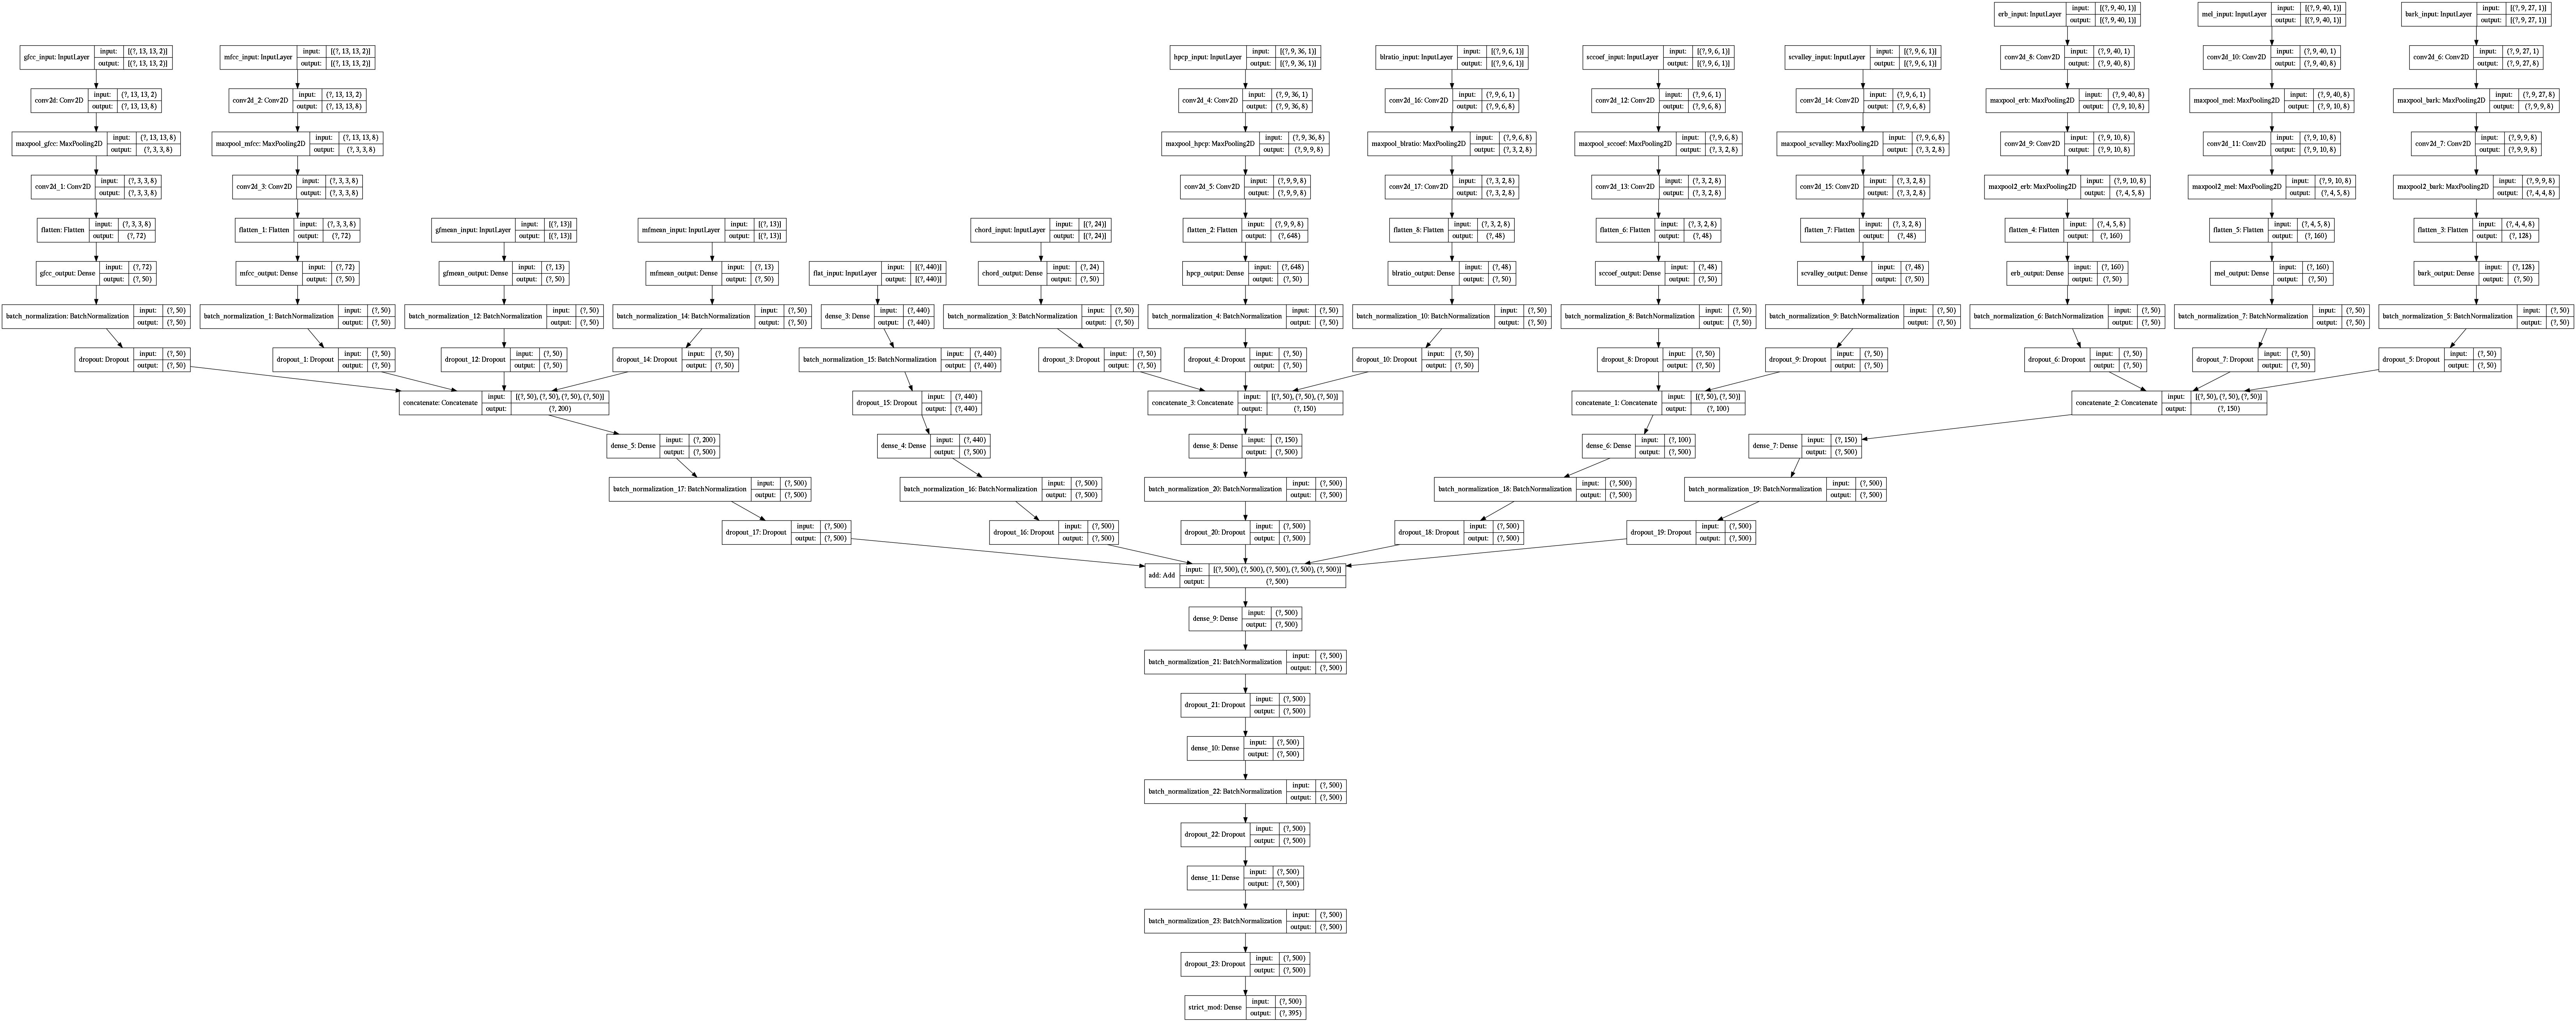

In [13]:
plot_model(finmod, to_file='model.png', show_shapes=True)

# Start Training

In [14]:
#finmod.load_weights('weights/training_weights{}-{}.h5'.format(start-1, interval))
history = finmod.fit(inputs[:-2], inputs[14], epochs=Epochs, validation_split=0.2,
                    batch_size=256, sample_weight = inputs[13])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 331112 samples, validate on 82778 samples
Epoch 1/1000
331112/331112 [==============================] - 29s 88us/sample - loss: 3.3999 - accuracy: 0.2888 - top3: 0.4574 - top5: 0.5450 - top10: 0.6681 - val_loss: 2.7179 - val_accuracy: 0.2883 - val_top3: 0.4470 - val_top5: 0.5303 - val_top10: 0.6457
Epoch 2/1000
331112/331112 [==============================] - 24s 72us/sample - loss: 2.4518 - accuracy: 0.3213 - top3: 0.5003 - top5: 0.5915 - top10: 0.7150 - val_loss: 2.6027 - val_accuracy: 0.2832 - val_top3: 0.4582 - val_top5: 0.5474 - val_top10: 0.6733
Epoch 3/1000
331112/331112 [==============================] - 24s 72us/sample - loss: 2.3727 - accuracy: 0.3332 - top3: 0.5139 - top5: 0.6058 - top10: 0.7289 - val_loss: 2.4860 - val_accuracy: 0.3040 - val_top3: 0.4748 - val_top5: 0.5704 - val_top10: 0.6957
Epoch 4/1000
331112/331112 [==============================] - 24s 72us/sample - loss: 2.3292 - accuracy: 0.3389 - top3: 0.521

Epoch 32/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 2.0995 - accuracy: 0.3737 - top3: 0.5671 - top5: 0.6607 - top10: 0.7791 - val_loss: 2.2467 - val_accuracy: 0.3428 - val_top3: 0.5278 - val_top5: 0.6194 - val_top10: 0.7415
Epoch 33/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 2.0959 - accuracy: 0.3744 - top3: 0.5682 - top5: 0.6609 - top10: 0.7794 - val_loss: 2.1472 - val_accuracy: 0.3655 - val_top3: 0.5586 - val_top5: 0.6509 - val_top10: 0.7691
Epoch 34/1000
331112/331112 [==============================] - 24s 72us/sample - loss: 2.0934 - accuracy: 0.3742 - top3: 0.5686 - top5: 0.6622 - top10: 0.7802 - val_loss: 2.0812 - val_accuracy: 0.3778 - val_top3: 0.5728 - val_top5: 0.6655 - val_top10: 0.7829
Epoch 35/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 2.0893 - accuracy: 0.3748 - top3: 0.5695 - top5: 0.6629 - top10: 0.7816 - val_loss: 2.1455 - val_accuracy: 0.3658 - val_top3: 0.5544 - v

Epoch 64/1000
331112/331112 [==============================] - 26s 77us/sample - loss: 2.0334 - accuracy: 0.3847 - top3: 0.5821 - top5: 0.6756 - top10: 0.7924 - val_loss: 2.0671 - val_accuracy: 0.3823 - val_top3: 0.5746 - val_top5: 0.6663 - val_top10: 0.7837
Epoch 65/1000
331112/331112 [==============================] - 26s 79us/sample - loss: 2.0322 - accuracy: 0.3849 - top3: 0.5825 - top5: 0.6756 - top10: 0.7931 - val_loss: 2.0649 - val_accuracy: 0.3790 - val_top3: 0.5749 - val_top5: 0.6690 - val_top10: 0.7869
Epoch 66/1000
331112/331112 [==============================] - 26s 79us/sample - loss: 2.0324 - accuracy: 0.3845 - top3: 0.5820 - top5: 0.6762 - top10: 0.7929 - val_loss: 2.1691 - val_accuracy: 0.3510 - val_top3: 0.5498 - val_top5: 0.6456 - val_top10: 0.7671
Epoch 67/1000
331112/331112 [==============================] - 26s 80us/sample - loss: 2.0298 - accuracy: 0.3855 - top3: 0.5831 - top5: 0.6765 - top10: 0.7923 - val_loss: 2.0725 - val_accuracy: 0.3788 - val_top3: 0.5712 - v

Epoch 96/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.9965 - accuracy: 0.3911 - top3: 0.5909 - top5: 0.6848 - top10: 0.8003 - val_loss: 2.0532 - val_accuracy: 0.3850 - val_top3: 0.5792 - val_top5: 0.6718 - val_top10: 0.7896
Epoch 97/1000
331112/331112 [==============================] - 27s 80us/sample - loss: 1.9984 - accuracy: 0.3895 - top3: 0.5898 - top5: 0.6838 - top10: 0.7998 - val_loss: 2.0566 - val_accuracy: 0.3838 - val_top3: 0.5802 - val_top5: 0.6727 - val_top10: 0.7877
Epoch 98/1000
331112/331112 [==============================] - 26s 77us/sample - loss: 1.9983 - accuracy: 0.3911 - top3: 0.5900 - top5: 0.6834 - top10: 0.7998 - val_loss: 2.0208 - val_accuracy: 0.3934 - val_top3: 0.5889 - val_top5: 0.6804 - val_top10: 0.7960
Epoch 99/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.9964 - accuracy: 0.3914 - top3: 0.5906 - top5: 0.6840 - top10: 0.7996 - val_loss: 2.0482 - val_accuracy: 0.3873 - val_top3: 0.5856 - v

331112/331112 [==============================] - 26s 78us/sample - loss: 1.9556 - accuracy: 0.3987 - top3: 0.5996 - top5: 0.6940 - top10: 0.8083 - val_loss: 1.9766 - val_accuracy: 0.3981 - val_top3: 0.5954 - val_top5: 0.6892 - val_top10: 0.8019
Epoch 159/1000
331112/331112 [==============================] - 27s 81us/sample - loss: 1.9546 - accuracy: 0.3993 - top3: 0.6007 - top5: 0.6942 - top10: 0.8082 - val_loss: 1.9702 - val_accuracy: 0.4009 - val_top3: 0.6004 - val_top5: 0.6915 - val_top10: 0.8030
Epoch 160/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.9534 - accuracy: 0.3996 - top3: 0.6005 - top5: 0.6946 - top10: 0.8081 - val_loss: 1.9837 - val_accuracy: 0.3967 - val_top3: 0.5943 - val_top5: 0.6864 - val_top10: 0.8007
Epoch 161/1000
331112/331112 [==============================] - 26s 77us/sample - loss: 1.9527 - accuracy: 0.3986 - top3: 0.6008 - top5: 0.6948 - top10: 0.8088 - val_loss: 1.9786 - val_accuracy: 0.3977 - val_top3: 0.5965 - val_top5: 0.

331112/331112 [==============================] - 26s 77us/sample - loss: 1.9312 - accuracy: 0.4036 - top3: 0.6054 - top5: 0.6990 - top10: 0.8131 - val_loss: 1.9611 - val_accuracy: 0.4037 - val_top3: 0.6015 - val_top5: 0.6940 - val_top10: 0.8053
Epoch 221/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.9307 - accuracy: 0.4028 - top3: 0.6047 - top5: 0.6995 - top10: 0.8135 - val_loss: 1.9762 - val_accuracy: 0.4018 - val_top3: 0.6009 - val_top5: 0.6916 - val_top10: 0.8041
Epoch 222/1000
331112/331112 [==============================] - 26s 77us/sample - loss: 1.9313 - accuracy: 0.4028 - top3: 0.6052 - top5: 0.6992 - top10: 0.8133 - val_loss: 1.9579 - val_accuracy: 0.4017 - val_top3: 0.6001 - val_top5: 0.6912 - val_top10: 0.8054
Epoch 223/1000
331112/331112 [==============================] - 26s 79us/sample - loss: 1.9303 - accuracy: 0.4032 - top3: 0.6051 - top5: 0.6991 - top10: 0.8131 - val_loss: 1.9512 - val_accuracy: 0.4036 - val_top3: 0.6020 - val_top5: 0.

331112/331112 [==============================] - 25s 75us/sample - loss: 1.9112 - accuracy: 0.4063 - top3: 0.6097 - top5: 0.7041 - top10: 0.8172 - val_loss: 1.9406 - val_accuracy: 0.4066 - val_top3: 0.6053 - val_top5: 0.6966 - val_top10: 0.8092
Epoch 283/1000
331112/331112 [==============================] - 25s 76us/sample - loss: 1.9113 - accuracy: 0.4072 - top3: 0.6098 - top5: 0.7038 - top10: 0.8165 - val_loss: 1.9982 - val_accuracy: 0.3929 - val_top3: 0.5869 - val_top5: 0.6796 - val_top10: 0.7944
Epoch 284/1000
331112/331112 [==============================] - 25s 77us/sample - loss: 1.9120 - accuracy: 0.4068 - top3: 0.6094 - top5: 0.7032 - top10: 0.8167 - val_loss: 1.9521 - val_accuracy: 0.4061 - val_top3: 0.6049 - val_top5: 0.6957 - val_top10: 0.8081
Epoch 285/1000
331112/331112 [==============================] - 25s 77us/sample - loss: 1.9103 - accuracy: 0.4067 - top3: 0.6101 - top5: 0.7037 - top10: 0.8171 - val_loss: 1.9408 - val_accuracy: 0.4052 - val_top3: 0.6030 - val_top5: 0.

331112/331112 [==============================] - 25s 76us/sample - loss: 1.8966 - accuracy: 0.4095 - top3: 0.6133 - top5: 0.7069 - top10: 0.8193 - val_loss: 1.9625 - val_accuracy: 0.4065 - val_top3: 0.6062 - val_top5: 0.6976 - val_top10: 0.8093
Epoch 345/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8975 - accuracy: 0.4095 - top3: 0.6129 - top5: 0.7059 - top10: 0.8195 - val_loss: 1.9538 - val_accuracy: 0.4030 - val_top3: 0.6006 - val_top5: 0.6920 - val_top10: 0.8051
Epoch 346/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 1.8963 - accuracy: 0.4099 - top3: 0.6135 - top5: 0.7069 - top10: 0.8198 - val_loss: 1.9279 - val_accuracy: 0.4075 - val_top3: 0.6088 - val_top5: 0.6990 - val_top10: 0.8102
Epoch 347/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 1.8961 - accuracy: 0.4093 - top3: 0.6135 - top5: 0.7071 - top10: 0.8200 - val_loss: 1.9498 - val_accuracy: 0.4111 - val_top3: 0.6105 - val_top5: 0.

331112/331112 [==============================] - 25s 77us/sample - loss: 1.8855 - accuracy: 0.4119 - top3: 0.6162 - top5: 0.7102 - top10: 0.8216 - val_loss: 1.9403 - val_accuracy: 0.4078 - val_top3: 0.6043 - val_top5: 0.6941 - val_top10: 0.8064
Epoch 407/1000
331112/331112 [==============================] - 25s 75us/sample - loss: 1.8849 - accuracy: 0.4110 - top3: 0.6159 - top5: 0.7094 - top10: 0.8213 - val_loss: 1.9189 - val_accuracy: 0.4122 - val_top3: 0.6107 - val_top5: 0.7008 - val_top10: 0.8118
Epoch 408/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8841 - accuracy: 0.4123 - top3: 0.6163 - top5: 0.7089 - top10: 0.8219 - val_loss: 1.9194 - val_accuracy: 0.4108 - val_top3: 0.6100 - val_top5: 0.7007 - val_top10: 0.8112
Epoch 409/1000
331112/331112 [==============================] - 25s 76us/sample - loss: 1.8844 - accuracy: 0.4117 - top3: 0.6166 - top5: 0.7097 - top10: 0.8213 - val_loss: 1.9383 - val_accuracy: 0.4106 - val_top3: 0.6101 - val_top5: 0.

331112/331112 [==============================] - 25s 75us/sample - loss: 1.8757 - accuracy: 0.4136 - top3: 0.6176 - top5: 0.7115 - top10: 0.8237 - val_loss: 1.9158 - val_accuracy: 0.4137 - val_top3: 0.6108 - val_top5: 0.7018 - val_top10: 0.8115
Epoch 469/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8754 - accuracy: 0.4141 - top3: 0.6186 - top5: 0.7120 - top10: 0.8238 - val_loss: 1.9220 - val_accuracy: 0.4087 - val_top3: 0.6078 - val_top5: 0.6997 - val_top10: 0.8112
Epoch 470/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8766 - accuracy: 0.4125 - top3: 0.6178 - top5: 0.7117 - top10: 0.8238 - val_loss: 1.9542 - val_accuracy: 0.4080 - val_top3: 0.6069 - val_top5: 0.6980 - val_top10: 0.8093
Epoch 471/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8754 - accuracy: 0.4135 - top3: 0.6186 - top5: 0.7120 - top10: 0.8240 - val_loss: 1.9310 - val_accuracy: 0.4117 - val_top3: 0.6108 - val_top5: 0.

331112/331112 [==============================] - 26s 78us/sample - loss: 1.8667 - accuracy: 0.4150 - top3: 0.6203 - top5: 0.7140 - top10: 0.8251 - val_loss: 1.9225 - val_accuracy: 0.4095 - val_top3: 0.6084 - val_top5: 0.6983 - val_top10: 0.8103
Epoch 531/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.8675 - accuracy: 0.4148 - top3: 0.6203 - top5: 0.7135 - top10: 0.8249 - val_loss: 1.9287 - val_accuracy: 0.4136 - val_top3: 0.6131 - val_top5: 0.7041 - val_top10: 0.8142
Epoch 532/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.8680 - accuracy: 0.4151 - top3: 0.6197 - top5: 0.7132 - top10: 0.8252 - val_loss: 1.9226 - val_accuracy: 0.4124 - val_top3: 0.6128 - val_top5: 0.7023 - val_top10: 0.8130
Epoch 533/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.8680 - accuracy: 0.4150 - top3: 0.6193 - top5: 0.7136 - top10: 0.8249 - val_loss: 1.9175 - val_accuracy: 0.4116 - val_top3: 0.6112 - val_top5: 0.

331112/331112 [==============================] - 25s 77us/sample - loss: 1.8605 - accuracy: 0.4169 - top3: 0.6216 - top5: 0.7156 - top10: 0.8265 - val_loss: 1.9027 - val_accuracy: 0.4139 - val_top3: 0.6131 - val_top5: 0.7034 - val_top10: 0.8138
Epoch 593/1000
331112/331112 [==============================] - 25s 76us/sample - loss: 1.8605 - accuracy: 0.4165 - top3: 0.6214 - top5: 0.7152 - top10: 0.8266 - val_loss: 1.9174 - val_accuracy: 0.4097 - val_top3: 0.6118 - val_top5: 0.7016 - val_top10: 0.8121
Epoch 594/1000
331112/331112 [==============================] - 25s 76us/sample - loss: 1.8591 - accuracy: 0.4167 - top3: 0.6219 - top5: 0.7151 - top10: 0.8268 - val_loss: 1.9065 - val_accuracy: 0.4119 - val_top3: 0.6122 - val_top5: 0.7024 - val_top10: 0.8137
Epoch 595/1000
331112/331112 [==============================] - 25s 76us/sample - loss: 1.8596 - accuracy: 0.4165 - top3: 0.6223 - top5: 0.7154 - top10: 0.8265 - val_loss: 1.9462 - val_accuracy: 0.4077 - val_top3: 0.6052 - val_top5: 0.

331112/331112 [==============================] - 25s 74us/sample - loss: 1.8534 - accuracy: 0.4187 - top3: 0.6231 - top5: 0.7172 - top10: 0.8277 - val_loss: 1.9017 - val_accuracy: 0.4126 - val_top3: 0.6135 - val_top5: 0.7041 - val_top10: 0.8146
Epoch 655/1000
331112/331112 [==============================] - 25s 75us/sample - loss: 1.8533 - accuracy: 0.4180 - top3: 0.6232 - top5: 0.7164 - top10: 0.8274 - val_loss: 1.8932 - val_accuracy: 0.4156 - val_top3: 0.6161 - val_top5: 0.7069 - val_top10: 0.8164
Epoch 656/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8544 - accuracy: 0.4174 - top3: 0.6224 - top5: 0.7165 - top10: 0.8278 - val_loss: 1.9055 - val_accuracy: 0.4113 - val_top3: 0.6117 - val_top5: 0.7027 - val_top10: 0.8128
Epoch 657/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8534 - accuracy: 0.4173 - top3: 0.6231 - top5: 0.7166 - top10: 0.8276 - val_loss: 1.8982 - val_accuracy: 0.4134 - val_top3: 0.6121 - val_top5: 0.

331112/331112 [==============================] - 25s 75us/sample - loss: 1.8485 - accuracy: 0.4182 - top3: 0.6242 - top5: 0.7183 - top10: 0.8298 - val_loss: 1.8967 - val_accuracy: 0.4155 - val_top3: 0.6150 - val_top5: 0.7066 - val_top10: 0.8161
Epoch 717/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8501 - accuracy: 0.4191 - top3: 0.6239 - top5: 0.7168 - top10: 0.8281 - val_loss: 1.8999 - val_accuracy: 0.4146 - val_top3: 0.6136 - val_top5: 0.7034 - val_top10: 0.8154
Epoch 718/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8513 - accuracy: 0.4178 - top3: 0.6233 - top5: 0.7166 - top10: 0.8279 - val_loss: 1.8974 - val_accuracy: 0.4140 - val_top3: 0.6137 - val_top5: 0.7034 - val_top10: 0.8148
Epoch 719/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8486 - accuracy: 0.4187 - top3: 0.6240 - top5: 0.7178 - top10: 0.8281 - val_loss: 1.8965 - val_accuracy: 0.4158 - val_top3: 0.6156 - val_top5: 0.

331112/331112 [==============================] - 25s 75us/sample - loss: 1.8448 - accuracy: 0.4192 - top3: 0.6254 - top5: 0.7185 - top10: 0.8294 - val_loss: 1.8992 - val_accuracy: 0.4166 - val_top3: 0.6167 - val_top5: 0.7076 - val_top10: 0.8174
Epoch 779/1000
331112/331112 [==============================] - 25s 75us/sample - loss: 1.8449 - accuracy: 0.4189 - top3: 0.6254 - top5: 0.7189 - top10: 0.8290 - val_loss: 1.8944 - val_accuracy: 0.4170 - val_top3: 0.6171 - val_top5: 0.7076 - val_top10: 0.8180
Epoch 780/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8447 - accuracy: 0.4184 - top3: 0.6249 - top5: 0.7189 - top10: 0.8300 - val_loss: 1.9017 - val_accuracy: 0.4132 - val_top3: 0.6141 - val_top5: 0.7032 - val_top10: 0.8146
Epoch 781/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8459 - accuracy: 0.4183 - top3: 0.6242 - top5: 0.7184 - top10: 0.8297 - val_loss: 1.9069 - val_accuracy: 0.4108 - val_top3: 0.6105 - val_top5: 0.

331112/331112 [==============================] - 24s 72us/sample - loss: 1.8403 - accuracy: 0.4190 - top3: 0.6270 - top5: 0.7204 - top10: 0.8308 - val_loss: 1.8880 - val_accuracy: 0.4153 - val_top3: 0.6161 - val_top5: 0.7052 - val_top10: 0.8169
Epoch 841/1000
331112/331112 [==============================] - 24s 73us/sample - loss: 1.8393 - accuracy: 0.4206 - top3: 0.6265 - top5: 0.7199 - top10: 0.8302 - val_loss: 1.9109 - val_accuracy: 0.4107 - val_top3: 0.6079 - val_top5: 0.7004 - val_top10: 0.8125
Epoch 842/1000
331112/331112 [==============================] - 24s 74us/sample - loss: 1.8408 - accuracy: 0.4199 - top3: 0.6256 - top5: 0.7188 - top10: 0.8299 - val_loss: 1.9080 - val_accuracy: 0.4111 - val_top3: 0.6102 - val_top5: 0.7014 - val_top10: 0.8135
Epoch 843/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8393 - accuracy: 0.4202 - top3: 0.6266 - top5: 0.7201 - top10: 0.8298 - val_loss: 1.8901 - val_accuracy: 0.4162 - val_top3: 0.6161 - val_top5: 0.

331112/331112 [==============================] - 26s 79us/sample - loss: 1.8358 - accuracy: 0.4208 - top3: 0.6276 - top5: 0.7204 - top10: 0.8305 - val_loss: 1.9159 - val_accuracy: 0.4123 - val_top3: 0.6110 - val_top5: 0.7023 - val_top10: 0.8136
Epoch 903/1000
331112/331112 [==============================] - 26s 78us/sample - loss: 1.8365 - accuracy: 0.4204 - top3: 0.6263 - top5: 0.7198 - top10: 0.8308 - val_loss: 1.8960 - val_accuracy: 0.4149 - val_top3: 0.6157 - val_top5: 0.7063 - val_top10: 0.8172
Epoch 904/1000
331112/331112 [==============================] - 26s 80us/sample - loss: 1.8353 - accuracy: 0.4213 - top3: 0.6272 - top5: 0.7207 - top10: 0.8313 - val_loss: 1.8916 - val_accuracy: 0.4156 - val_top3: 0.6160 - val_top5: 0.7062 - val_top10: 0.8165
Epoch 905/1000
331112/331112 [==============================] - 27s 80us/sample - loss: 1.8371 - accuracy: 0.4207 - top3: 0.6264 - top5: 0.7205 - top10: 0.8298 - val_loss: 1.8991 - val_accuracy: 0.4128 - val_top3: 0.6135 - val_top5: 0.

331112/331112 [==============================] - 25s 74us/sample - loss: 1.8304 - accuracy: 0.4218 - top3: 0.6284 - top5: 0.7218 - top10: 0.8323 - val_loss: 1.8740 - val_accuracy: 0.4197 - val_top3: 0.6204 - val_top5: 0.7097 - val_top10: 0.8205
Epoch 965/1000
331112/331112 [==============================] - 25s 75us/sample - loss: 1.8316 - accuracy: 0.4208 - top3: 0.6284 - top5: 0.7223 - top10: 0.8319 - val_loss: 1.8767 - val_accuracy: 0.4191 - val_top3: 0.6197 - val_top5: 0.7105 - val_top10: 0.8206
Epoch 966/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8324 - accuracy: 0.4215 - top3: 0.6276 - top5: 0.7214 - top10: 0.8320 - val_loss: 1.9030 - val_accuracy: 0.4139 - val_top3: 0.6146 - val_top5: 0.7054 - val_top10: 0.8161
Epoch 967/1000
331112/331112 [==============================] - 25s 74us/sample - loss: 1.8315 - accuracy: 0.4224 - top3: 0.6285 - top5: 0.7213 - top10: 0.8316 - val_loss: 1.8799 - val_accuracy: 0.4174 - val_top3: 0.6182 - val_top5: 0.

Save Models Here:

In [16]:
#finmod.save('models/final_model3.h5')

In [17]:
#finmod.save_weights('weights/final_weights3.h5')

# Plot the Results

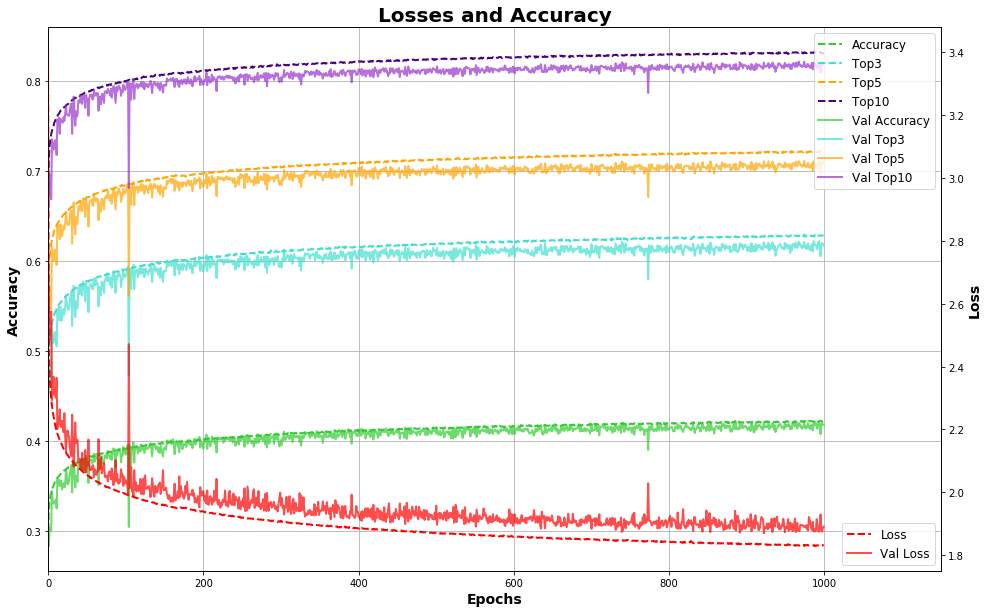

In [18]:
fig, ax1 = plt.subplots(figsize = (16,10))
ax1.grid(True)
ax1.set_xlim(0, Epochs+(Epochs*0.15))
ax2 = ax1.twinx()
ax1.plot(range(Epochs), history.history['accuracy'], 'limegreen', linestyle = 'dashed', label='Accuracy', lw=2)
ax1.plot(range(Epochs), history.history['top3'], 'turquoise', linestyle = 'dashed', label='Top3', lw =2)
ax1.plot(range(Epochs), history.history['top5'], 'orange', linestyle = 'dashed', label='Top5', lw =2)
ax1.plot(range(Epochs), history.history['top10'], 'indigo', linestyle = 'dashed', label='Top10', lw =2)

ax1.plot(range(Epochs), history.history['val_accuracy'], 'limegreen', alpha=0.7, label='Val Accuracy', lw =2)
ax1.plot(range(Epochs), history.history['val_top3'], 'turquoise', alpha=0.7, label='Val Top3', lw =2)
ax1.plot(range(Epochs), history.history['val_top5'], 'orange', alpha=0.7, label='Val Top5', lw =2)
ax1.plot(range(Epochs), history.history['val_top10'], 'darkorchid', alpha=0.7, label='Val Top10', lw =2)

ax2.plot(range(Epochs), history.history['loss'], 'red', linestyle = 'dashed', label='Loss',lw =2)
ax2.plot(range(Epochs), history.history['val_loss'], 'red', alpha=0.7, label='Val Loss', lw =2)

ax1.set_xlabel('Epochs', fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax1.set_ylabel('Accuracy', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax2.set_ylabel('Loss',fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax1.set_title("Losses and Accuracy", fontdict = {'fontsize': 20, 'fontweight': 'bold'})
ax1.legend(fontsize='large', loc=1)
ax2.legend(fontsize='large', loc=4)
plt.show()

In [23]:
hist = pd.DataFrame(history.history)
hist.to_parquet('model_history3.parquet', compression='snappy')

In [24]:
hist

,loss,accuracy,top3,top5,top10,val_loss,val_accuracy,val_top3,val_top5,val_top10
0,3.399879,0.288772,0.457353,0.544991,0.668070,2.717877,0.288313,0.447027,0.530346,0.645667
1,2.451812,0.321329,0.500347,0.591465,0.715045,2.602746,0.283240,0.458177,0.547428,0.673319
2,2.372749,0.333223,0.513868,0.605768,0.728892,2.486036,0.304030,0.474764,0.570429,0.695716
3,2.329207,0.338864,0.521452,0.613702,0.735709,2.496210,0.304477,0.480985,0.568436,0.694979
4,2.298025,0.342621,0.527039,0.619579,0.741272,2.574659,0.300382,0.460183,0.546860,0.668741
...,...,...,...,...,...,...,...,...,...,...
995,1.830060,0.422558,0.628506,0.721614,0.831978,1.929814,0.407645,0.605402,0.696622,0.809623
996,1.830207,0.422473,0.628458,0.721360,0.831824,1.886140,0.418734,0.618703,0.708848,0.818418
997,1.831325,0.421138,0.628793,0.721768,0.831281,1.875172,0.419049,0.620044,0.710612,0.820327
998,1.832403,0.422081,0.628343,0.721164,0.830991,1.887114,0.418130,0.618631,0.708739,0.818285


We see a light overfitting but that's ok but it seems like we are converging on a solution. The validation and training metrics seems to be diverging ever so slightly which probably means that we won't get anything better than this. 

I will be discussing the results of my model in the next section